# CS224N Assignment 1: Exploring Word Vectors (25 Points)

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. 

# CS224N作业1：探索词向量（25分）
欢迎使用CS224n！

在开始之前，请确保已在与此笔记本相同的目录中阅读README.txt。

# 前提条件

pip install gensim

pip3 install nltk

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...


## Please Write Your SUNet ID Here: 

## 请在此处输入您的SUNet ID：

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## 单词向量

字向量通常用作下游NLP任务的基本组件，例如 问题解答，文本生成，翻译等，因此重要的是要就其优缺点建立一些直觉。 在这里，您将探索两种类型的词向量：从“共现矩阵”派生的词向量和通过“ word2vec *”派生的词向量。

**分配注意事项：**请确保随身携带笔记本。 提交说明位于笔记本计算机的底部。

**术语说明：**术语“单词向量”和“单词嵌入”通常可以互换使用。 术语“嵌入”是指我们在较低维度的空间中编码单词含义的各个方面。 正如[Wikipedia](https://en.wikipedia.org/wiki/Word_embedding)所述，“ *从概念上讲，它涉及从每个单词一维的空间到具有更低维度的连续向量空间的数学嵌入*”。

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

## 第1部分：基于计数的单词向量（10分）
大多数单词向量模型都从以下想法开始：

您将知道它所保留的公司的一个词（Firth，J. R. 1957：11）

许多单词向量的实现是受这样的想法驱使的：在相似的上下文中将使用相似的单词，即（近）同义词。 结果，经常会说出或写出相似的单词以及单词的共享子集，即上下文。 通过检查这些上下文，我们可以尝试为我们的单词开发嵌入。 考虑到这种直觉，许多“老派”方法构造词向量都依赖于词数。 在这里，我们详细介绍其中一种策略，共现矩阵（有关更多信息，请参见[此处](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf)或[此处](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)）。

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

### 共现

共现矩阵计算事物在某些环境中共现的频率。 给定文档中出现的单词$ w_i $，我们考虑$ w_i $周围的*上下文窗口*。 假设我们的固定窗口大小为$ n $，则这是该文档中$ n $前面的单词和$ n $后面的单词，即单词$ w_ {in} \ dots w_ {i-1} $和$ w_ {i + 1} \ dots w_ {i + n} $。 我们建立一个*共现矩阵* $ M $，它是一个对称的逐字矩阵，其中$ M_ {ij} $是$ w_j $在$ w_i $的窗口内出现的次数。

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

**注意：** 在NLP中，我们经常添加START和END标记来表示句子，段落或文档的开头和结尾。在这种情况下，我们可以想象一下封装每个文档的START和END令牌，例如“ START闪闪发光的不是金色END”，并将这些令牌包含在我们的同现计数中。

该矩阵的行（或列）提供一种类型的词向量（基于词-词共现的词向量），但这些向量通常较大（语料库中不同词的数目呈线性关系）。因此，我们的下一步是运行*降维*。特别是，我们将运行* SVD（奇异值分解）*，这是一种广义的* PCA（主成分分析）*，用于选择顶部的$ k $主成分。这是SVD降维的可视化。在这张图片中，我们的共现矩阵是$ A $，其中$ n $行对应于$ n $个单词。我们获得了完整的矩阵分解，其中奇异值在对角$ S $矩阵中排序，而新的，较短的$ k $字向量在$ U_k $中。

![Picture of an SVD](imgs/svd.png)

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as *[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)* — then there are reasonably scalable techniques to compute those iteratively.

这种降维共现表示保留了单词之间的语义关系，例如医生和医院比医生和狗更近。

注意：如果您几乎不记得什么是特征值，那么这里是对SVD的缓慢而友好的介绍。如果您想更全面地了解PCA或SVD，请随时查阅CS168的第7、8和9讲。这些课程笔记对这些通用算法提供了很好的高级处理。但是，出于此类的目的，您只需要知道如何通过从numpy，scipy或sklearn python包中利用这些算法的预编程实现来提取k维嵌入。实际上，由于执行PCA或SVD所需的内存，将完整的SVD应用于大型语料库具有挑战性。但是，如果只希望相对较小的the的顶部𝑘向量分量（称为* Trenchated SVD *），则可以使用合理可扩展的技术来迭代计算这些分量。

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do **not** have perform any other kind of pre-processing.


### 绘制共现单词嵌入

在这里，我们将使用路透社（商业和金融新闻）语料库。 如果您尚未运行此页面顶部的导入单元格，请立即运行它（单击它并按SHIFT-RETURN）。 语料库由10,788个新闻文档组成，总计130万字。 这些文档涵盖90个类别，分为培训和测试。 有关更多详细信息，请参见https://www.nltk.org/book/ch02.html。 我们在下面提供了一个“ read_corpus”功能，该功能仅提取“粗略”类别中的文章（即有关石油，天然气等的新闻报道）。 该函数还将START和END令牌添加到每个文档中，并小写单词。 您**没有**已执行任何其他类型的预处理。

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

让我们看一下这些文档是什么样的……

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

### 问题1.1：实现`distinct_words` [代码]（2分）

编写一种方法，计算出语料库中出现的不同单词（单词类型）。 您可以使用`for`循环来执行此操作，但是使用Python列表推导方法则更有效。 特别地，[this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python)可能对扁平化列表列表很有用。 如果您一般不熟悉Python列表推导，请查看[更多信息](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html)。

您可能会发现使用[Python sets](https://www.w3schools.com/python/python_sets.asp)删除重复的单词很有用。

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words = sorted(set(np.concatenate(corpus)))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [6]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
print(test_corpus)
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

[['START', 'All', 'that', 'glitters', "isn't", 'gold', 'END'], ['START', "All's", 'well', 'that', 'ends', 'well', 'END']]
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


### 问题1.2：实现`compute_co_occurrence_matrix` [代码]（3分）

编写一种方法，为某个窗口大小的$ n $（默认值为4）构造一个共现矩阵，并考虑窗口中心的单词之前的$ n $和后面的$ n $。 在这里，我们开始使用“ numpy（np）”来表示向量，矩阵和张量。 如果您不熟悉NumPy，则此cs231n [Python NumPy教程](http://cs231n.github.io/python-numpy-tutorial/)的下半部分有一个NumPy教程。


In [9]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    # ------------------
    # Write your implementation here.
    
    word2Ind = dict(zip(words, range(len(words))))
    M = np.zeros((len(words),len(words)), dtype=float)
    
    # 遍历语料库的所有句子
    for row,array in  enumerate(corpus):
        # 遍历每个句子的每个单词并把这个单词作为焦点词
        for col,focus_word in enumerate(array):
            #根据窗口大小，向右取相应单词
            max_cnt = col + window_size + 1
            if(max_cnt > len(array)):
                max_cnt = len(array)
            # 根据窗口大小，向左取相应单词
            min_cnt = col - window_size
            if(min_cnt < 0):
                min_cnt = 0
            # 统计焦点词右侧的单词
            for right in range(col+1,max_cnt):
                m_row = word2Ind[focus_word]
                m_col = word2Ind[array[right]]

                M[m_row,m_col] = M[m_row,m_col] + 1
            # 统计焦点词左侧侧的单词
            for left in range(min_cnt,col):
                m_row = word2Ind[focus_word]
                m_col = word2Ind[array[left]]

                M[m_row,m_col] = M[m_row,m_col] + 1

    # ------------------

    return M, word2Ind

In [10]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

### 问题1.3：实现reduce_to_k_dim [代码]（1分）¶
构造一种对矩阵执行降维以生成k维嵌入的方法。 使用SVD提取前k个分量，并生成一个新的k维嵌入矩阵。

注意：所有numpy，scipy和scikit-learn（sklearn）都提供了SVD的某些实现，但是只有scipy和sklearn提供了Truncated SVD的实现，并且只有sklearn提供了有效的随机算法来计算大规模的Truncated SVD。 因此，请使用[sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)。

In [30]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.

    reducer = TruncatedSVD(n_components=k, n_iter=n_iters)
    reducer.fit(M)
    M_reduced = reducer.transform(M)

        # ------------------

    print("Done.")
    return M_reduced

In [31]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

### 问题1.4：实现plot_embeddings [代码]（1分）
在这里，您将编写一个函数来在2D空间中绘制一组2D向量。 对于图形，我们将使用Matplotlib（plt）。

对于此示例，您可能会发现修改[此代码](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/)很有用。 将来，制作绘图的一种好方法是查看[Matplotlib图库](https://matplotlib.org/gallery/index.html)，找到看起来像您想要的绘图，并改编他们提供的代码。

In [103]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        x = M_reduced[word2Ind[word],0]
        y = M_reduced[word2Ind[word],1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    plt.show()
        
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


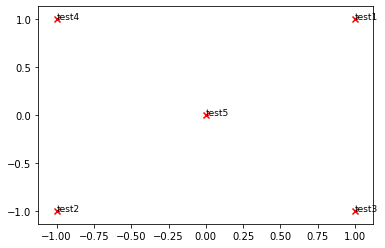

--------------------------------------------------------------------------------


In [104]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

### 问题1.5：共现图分析[撰写]（3分）

现在，我们将整理您编写的所有部分！我们将在路透社“原始”语料库上计算固定窗口为4的共现矩阵。然后，我们将使用TruncatedSVD计算每个单词的二维嵌入。 TruncatedSVD返回U \ * S，因此我们对返回的向量进行归一化，以便所有向量都将出现在单位圆周围（因此，紧密度是方向紧密度）。 **注意**：进行规范化的以下代码行使用*广播*的NumPy概念。如果您不了解广播，请查看
[数组计算：Jake VanderPlas的广播](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html)。

运行下面的单元格以生成绘图。运行可能要花几秒钟。哪些元素在二维嵌入空间中聚在一起？您可能认为应该将哪些不聚在一起？ **注意：**“ bpd”代表“每天的桶数”，是原油主题文章中的常用缩写。

Running Truncated SVD over 8185 words...
Done.


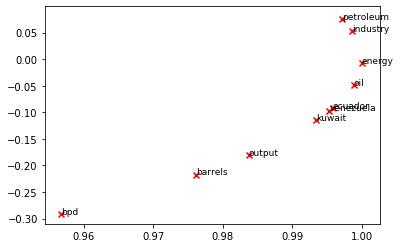

In [105]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

## 第2部分：基于预测的单词向量（15分）
如课堂上所讨论的，最近基于预测的词向量已经流行起来，例如 word2vec。 在这里，我们将探讨word2vec产生的嵌入。 请重新阅读课堂笔记和讲义幻灯片，以获取有关word2vec算法的更多详细信息。 如果您喜欢冒险，请挑战自己并尝试阅读[原始论文](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)。

然后运行以下单元以将word2vec向量加载到内存中。 注意：这可能需要几分钟。

In [106]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [107]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

Loaded vocab size 3000000


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

**注意：如果您在本地计算机上收到内存不足的问题，请尝试关闭其他应用程序以释放设备上的更多内存。 您可能想尝试重新启动计算机，以便释放更多的内存。 然后立即运行jupyter笔记本，看看是否可以正确加载单词向量。 如果在此之后仍无法将嵌入内容加载到本地计算机上，请按照Piazza说明进行操作，以了解如何在Stanford Farmshare计算机上远程运行。**

### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

### 减少Word2Vec单词嵌入的维数
让我们直接比较word2vec嵌入和共现矩阵的嵌入。 运行以下单元格以：

1.将300万个word2vec向量放入矩阵M

2.运行reduce_to_k_dim（您的截断的SVD函数）将矢量从300维缩减为2维。

In [108]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [109]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis [written] (4 points)

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

### 问题2.1：Word2Vec图解分析[撰写]（4分）

在下面的单元格中绘制“`['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`。

哪些元素在二维嵌入空间中聚在一起？ 您可能认为应该将哪些不聚在一起？ 该图与先前从共现矩阵生成的图有何不同？

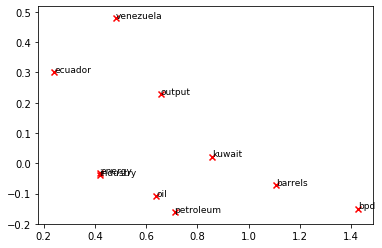

In [110]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

#### <font color="red">Write your answer here.</font>

#### <font color ="red">在此处写下您的答案。</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

### 余弦相似度
现在我们有了单词向量，我们需要一种根据这些向量来量化单个单词之间相似度的方法。 一种这样的度量是余弦相似度。 我们将使用它来查找彼此“接近”和“远离”的词。

我们可以将n维向量视为n维空间中的点。 如果从这个角度来看，L1和L2距离有助于量化在这两个点之间必须经过的空间量。 另一种方法是检查两个向量之间的角度。 从三角学我们知道：
<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

代替计算实际角度，我们可以按照$相似度= cos（\ Theta）$保留相似度。 形式上，两个向量$ p $和$ q $之间的[余弦相似度]（https://en.wikipedia.org/wiki/Cosine_similarity）$ s $定义为：

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Polysemous Words (2 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

### 问题2.2：多义词（2分）[代码+书面]
查找一个[polysemous](https://en.wikipedia.org/wiki/Polysemy)单词（例如，“ leaves”或“ scoop”），以使前10个最相似的单词（根据余弦相似性）包含相关的来自*两个*含义的单词。例如，“叶子”在前10名中同时具有“消失”和“茎”，而“瓢”中既具有“ handed_waffle_cone”又具有“ lowdown”。在找到一个单词之前，您可能需要尝试几个单词。请说明您发现的多义词以及在前10名中出现的多种含义。为什么您认为尝试过的许多多义词不起作用？

**注意**：您应该使用wv_from_bin.most_like（word）函数来获取前10个相似的单词。此功能根据与给定单词的余弦相似度对词汇表中的所有其他单词进行排名。要获得更多帮助，请检查[GenSim文档](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__。

In [111]:
# ------------------
# Write your polysemous word exploration code here.
wv_from_bin.most_similar("scoop")

# ------------------

[('scoops', 0.6741111278533936),
 ('scooped', 0.5712401270866394),
 ('Royal_Wedding_Meltdowns', 0.5508615374565125),
 ('Restrictions_Leash', 0.5447814464569092),
 ('Use_melon_baller', 0.5258612632751465),
 ('scooping', 0.5147117376327515),
 ('news@morehorror.com', 0.5114910006523132),
 ('handed_waffle_cone', 0.49177810549736023),
 ('lowdown', 0.4857146143913269),
 ('techie_breakie', 0.47323939204216003)]

#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>


### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

### 问题2.3：同义词和反义词（2分）[代码+书面]
在考虑余弦相似度时，通常更方便的是考虑余弦距离，即1-余弦相似度。

找到三个单词（w1，w2，w3），其中w1和w2是同义词，w1和w3是反义词，但余弦距离（w1，w3）<余弦距离（w1，w2）。 例如，w1 =“ happy”比w2 =“ cheerful”更接近w3 =“ sad”。

找到示例后，请提供可能的解释，说明为什么可能会发生这种违反直觉的结果。

您应该在此处使用wv_from_bin.distance（w1，w2）函数，以便计算两个单词之间的余弦距离。 请参阅[GenSim文档](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)以获取更多帮助。

In [112]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "happy"
w2 = "cheerful"
w3 = "sad"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms happy, cheerful have cosine distance: 0.6162261664867401
Antonyms happy, sad have cosine distance: 0.46453857421875


#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

### 用词向量解决类比
已显示Word2Vec向量有时表现出解决类比的能力。

例如，对于类比“男人：国王：：女人：x”，x是什么？

在下面的单元格中，我们向您展示如何使用词向量查找x。 most_similar函数查找与肯定列表中的单词最相似且与否定列表中的单词最相似的单词。 类比的答案将是排名最相似（最大数值）的单词。

注意：有关most_同类功能的更多文档可以在[GenSim文档](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)中找到。

In [113]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.518113374710083),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

### 问题2.4：寻找类比[代码+书面]（2分）
找到一个根据这些向量进行类推的示例（即，预期单词排在最前面）。 在您的解决方案中，请以x：y :: a：b的形式说明完整的类比。 如果您认为类比很复杂，请解释为什么类比只用一两个句子。

**注意**：您可能必须尝试许多类比才能找到可行的方法！

In [114]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['gymnast', 'piano'], negative=['gymnastics']))

# ------------------

[('pianist', 0.7164468169212341),
 ('violin', 0.7020024061203003),
 ('violinist', 0.681442379951477),
 ('cello', 0.6716278791427612),
 ('cellist', 0.6693906784057617),
 ('saxophone', 0.6536856889724731),
 ('clarinet', 0.6517087817192078),
 ('alto_saxophone', 0.6199961304664612),
 ('alto_sax', 0.6194193363189697),
 ('trombone', 0.6166050434112549)]


#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

### 问题2.5：类比错误[代码+书面]（1分）
找到一个不符合这些向量的类比示例。 在您的解决方案中，以x：y :: a：b的形式说明预期的类比，并根据单词向量说明b的（不正确）值。

In [115]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['grape', 'vegetable'], negative=['tomato']))

# ------------------

[('grapes', 0.5778293013572693),
 ('Thompson_seedless_grapes', 0.5553233027458191),
 ('grape_cultivation', 0.5311552286148071),
 ('winegrapes', 0.5253068208694458),
 ('wine_grapes', 0.5252600908279419),
 ('winegrape', 0.5084421038627625),
 ('varietal', 0.5068702697753906),
 ('Bordeaux_grape_varieties', 0.5039265751838684),
 ('almond', 0.4998564124107361),
 ('Cabernet_Sauvignon_grapes', 0.49503305554389954)]


#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

### 问题2.6：词向量中偏差的导引分析[撰写]（1分）

重要的是要认识到词嵌入所隐含的偏见（性别，种族，性取向等）。

运行下面的单元格，检查（a）哪些术语与“女人”和“老板”最相似，而与“男人”最不相似；以及（b）哪些术语与“男人”和“ boss”最相似，并且大多数 与“女人”不同。 您在前10名中找到什么？

In [116]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.459408164024353),
 ('Manageress', 0.45598435401916504),
 ('receptionist', 0.4474116861820221),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.44275766611099243),
 ('Coronation_Street_actress', 0.44275569915771484),
 ('supremo', 0.4409852921962738),
 ('coworker', 0.4398624897003174)]

[('supremo', 0.6097397804260254),
 ('MOTHERWELL_boss', 0.5489562153816223),
 ('CARETAKER_boss', 0.5375303626060486),
 ('Bully_Wee_boss', 0.5333974361419678),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256163477897644),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (2 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

### 问题2.7：字向量中的偏见的独立分析[代码+书面]（2分）

使用`most_similar`功能可以找到矢量出现某种偏差的另一种情况。 请简要说明您发现的偏见示例。

In [ ]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['american', 'manager'], negative=['chinese']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[,], negative=[]))

# ------------------

#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

### Question 2.8: Thinking About Bias [written] (1 point)

What might be the cause of these biases in the word vectors?

### 问题2.8：关于偏见的思考[撰写]（1分）

单词向量中这些偏差的原因可能是什么？

#### <font color="red">Write your answer here.</font>
#### <font color ="red">在此处写下您的答案。</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your SUNET ID above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
7. Submit your PDF on Gradescope.

# <font color="blue"> 提交说明</font>

1. 单击Jupyter Notebook顶部的“保存”按钮。
2. 请确保已在上面输入您的SUNET ID。
3. 选择单元格->所有输出->清除。 这将清除所有单元的所有输出（但将保留11个单元的内容）。
4. 选择单元格->全部运行。 这将按顺序运行所有单元，将需要几分钟。
5. 重新运行所有内容后，选择File-> Download as->通过LaTeX PDF
6. 查看PDF文件，并确保所有解决方案均正确显示。 PDF是您的评分员唯一会看到的东西！
7. 在Gradescope上提交您的PDF。